## Coordinate frame calibration for the experimental and testing purposes

### Extraction methods and HTM creation

In [5]:
import bagpy
from bagpy import bagreader
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as Rot
from bagpy import bagreader
import numpy as np

def extract_odom(odom): 
    x = odom['pose.position.x']
    y = odom['pose.position.y']
    z = odom['pose.position.z']
    qx = odom['pose.orientation.x']
    qy = odom['pose.orientation.y']
    qz = odom['pose.orientation.z']
    qw = odom['pose.orientation.w']
    return x,y,z,qx,qy,qz,qw

def extract_nav_odom(nav_odom): 
    t = nav_odom['Time']
    x = nav_odom['pose.pose.position.x']
    y = nav_odom['pose.pose.position.y']
    z = nav_odom['pose.pose.position.z']
    qx = nav_odom['pose.pose.orientation.x']
    qy = nav_odom['pose.pose.orientation.y']
    qz = nav_odom['pose.pose.orientation.z']
    qw = nav_odom['pose.pose.orientation.w']
    return t, x,y,z,qx,qy,qz,qw

# Convert extracted odometry to the T
def convT(x,y,z,qx,qy,qz,qw): 
    R = quat2rot((qx, qy, qz, qw))
    p = np.array([x, y, z]).reshape(3, 1)
    T = np.hstack((R, p))
    T = np.vstack((T, np.array([0, 0, 0, 1])))
    return T

def create_T_list(x, y, z, qx, qy, qz, qw):
    T_list = []
    for x_,y_,z_,qx_,qy_,qz_,qw_ in zip(x,y,z,qx,qy,qz,qw): 
        T_ = convT(x_,y_,z_, qx_,qy_,qz_,qw_)
        T_list.append(T_)
    return T_list

# Convert quaternion to the rotational matrix
def quat2rot(q):
    x, y, z, w = q
    r = Rot.from_quat([x, y, z, w])
    return r.as_matrix()

def zeroRot(T): 
    T[:3, :3] = np.eye(3)
    return T
def extractP(T): 
    x_ = [T_[0, 3] for T_ in T]
    y_ = [T_[1, 3] for T_ in T]
    z_ = [T_[2, 3] for T_ in T]
    return x_, y_, z_

## 2D plotter methods for different sensor sources

In [53]:
def plotT(T): 
    x_, y_, z_ = extractP(T)
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
    ax1.plot(range(0, len(T)), x_, color='r', label='x')
    ax2.plot(range(0, len(T)), y_, color='g', label='y')
    ax3.plot(range(0, len(T)), z_, color='b', label='z')
    
def plotTs(Tuav, Tee, Test): 
    x_uav, y_uav, z_uav = extractP(Tuav)
    x_ee, y_ee, z_ee = extractP(Tee)
    x_est, y_est, z_est = extractP(Test)
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15), sharex=True)
    ax1.plot(range(0, len(Tuav)), x_uav, color='r', label='x_uav')
    ax1.plot(range(0, len(Tee)), x_ee, color='g', label='x_ee', linestyle='--')
    ax1.plot(range(0, len(Test)), x_est, color='b', label='x_est', linestyle='-.')
    ax1.legend()
    ax1.grid()
    
    ax2.plot(range(0, len(Tuav)), y_uav, color='r', label='y_uav')
    ax2.plot(range(0, len(Tee)), y_ee, color='g', label='y_ee', linestyle='--')
    ax2.plot(range(0, len(Test)), y_est, color='b', label='y_est', linestyle='-.')
    ax2.legend()
    ax2.grid()
    
    ax3.plot(range(0, len(Tuav)), z_uav, color='r', label='z_uav')
    ax3.plot(range(0, len(Tee)), z_ee, color='g', label='z_ee', linestyle='--')
    ax3.plot(range(0, len(Test)), z_est, color='b', label='z_est', linestyle='-.')
    ax3.legend()
    ax3.grid()

def plot_vio_vs_opti(T_vio, T_opti): 
    x_vio, y_vio, z_vio = extractP(T_vio)
    x_opti, y_opti, z_opti = extractP(T_opti)
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15), sharex=True)
    ax1.plot(range(0, len(T_vio)), x_vio, color='r', label='x_vio')
    ax1.plot(range(0, len(T_opti)), x_opti, color='g', label='x_opti', linestyle='--')
    ax1.legend()
    ax1.grid()
    
    ax2.plot(range(0, len(T_vio)), y_vio, color='r', label='y_vio')
    ax2.plot(range(0, len(T_opti)), y_opti, color='g', label='y_opti', linestyle='--')
    ax2.legend()
    ax2.grid()
    
    ax3.plot(range(0, len(T_vio)), z_vio, color='r', label='z_vio')
    ax3.plot(range(0, len(T_opti)), z_opti, color='g', label='z_opti', linestyle='--')
    ax3.legend()
    ax3.grid()

def plot_kf_vs_opti(t_kf, t_opti, T_vio, T_opti): 
    x_vio, y_vio, z_vio = extractP(T_vio)
    x_opti, y_opti, z_opti = extractP(T_opti)
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15), sharex=True)
    ax1.plot(t_kf, x_vio, color='r', label='x_kf')
    ax1.plot(t_opti, x_opti, color='g', label='x_opti', linestyle='--')
    ax1.legend()
    ax1.grid()
    
    ax2.plot(t_kf, y_vio, color='r', label='y_kf')
    ax2.plot(t_opti, y_opti, color='g', label='y_opti', linestyle='--')
    ax2.legend()
    ax2.grid()
    
    ax3.plot(t_kf, z_vio, color='r', label='z_kf')
    ax3.plot(t_opti, z_opti, color='g', label='z_opti', linestyle='--')
    ax3.legend()
    ax3.grid()

## Read collected data into dataframes

In [7]:
fpth = './bags/wt1_flynav.bag'
opth = './bags/wt1_opti.bag'

bag1 = bagreader(fpth)
    
fo1 = bag1.message_by_topic('/flynav/vio_odom')
fo2 = bag1.message_by_topic('/kalman_scan2map_node/odometry_ros')
fo3 = bag1.message_by_topic('/flynav/force')
    
df_vio = pd.read_csv(fo1)
df_kf = pd.read_csv(fo2)
df_ff = pd.read_csv(fo3)

bag2 = bagreader(opth)

oo1 = bag2.message_by_topic('/mocap_helper/opt_elios_pose')
oo2 = bag2.message_by_topic('/mocap_helper/opt_ee_pose')

df_opt_elios = pd.read_csv(oo1)
df_opt_ee = pd.read_csv(oo2)

[INFO]  Data folder ./bags/wt1_flynav already exists. Not creating.
[INFO]  Data folder ./bags/wt1_opti already exists. Not creating.


## Create vectors and HTM

In [8]:
x,y,z,qx,qy,qz,qw = extract_odom(df_opt_elios)
T_uav = create_T_list(x, y, z, qx, qy, qz, qw)
x_ee, y_ee, z_ee, qx_ee, qy_ee, qz_ee, qw_ee = extract_odom(df_opt_ee)
T_ee = create_T_list(x_ee, y_ee, z_ee, qx_ee, qy_ee, qz_ee, qw_ee)

t_vio, x_vio, y_vio, z_vio, qx_vio, qy_vio, qz_vio, qw_vio = extract_nav_odom(df_vio)
t_kf, x_kf, y_kf, z_kf, qx_kf, qy_kf, qz_kf, qw_kf = extract_nav_odom(df_kf)

T_vio = create_T_list(x_vio, y_vio, z_vio, qx_vio, qy_vio, qz_vio, qw_vio)
T_kf = create_T_list(x_kf, y_kf, z_kf, qx_kf, qy_kf, qz_kf, qw_kf)

## Transformation matrices

### Cilj je pretvoriti mjerenja iz koordinatnog sustava vizualne odometrije u koordinatni sustav svijeta iz optitracka

* Provjeriti što je skupljeno do sada i što imamo 
* Zapisati formalizam koji je korišten, napredujemo u nekom smjeru ali je y i dalje sj...

## Convention for transformation matrices, for easier developing further on: 

Each variable will be saved as: 

* `wTb` is: $\mathbf{T}_W^B$ which basically means that we express robot base frame (B) in the world frame (W)  
* `bTw` is: $\mathbf{T}_B^W$ means that we express world frame (W) in the robot base frame (B)
* `bTe` is: $\mathbf{T}_B^E$ we express end effector frame (E) in the base frame (B) 
* `0T1` is: $\mathbf{T}_0^1$ we express coordinate frame of the joint 1 (1) in the coordinate frame of the joint 0 (0)
* `1T2` is: $\mathbf{T}_1^2$ we express coordinate frame of the joint 2 (2) in the coordinate frame of the joint 1 (1)
* `wTb*bTe = wTe` or $\mathbf{T}_W^B \mathbf{T}_B^E = \mathbf{T}_W^E$
* `0T1*1T2 = 0T2` or $\mathbf{T}_0^1 \mathbf{T}_1^2 = \mathbf{T}_0^2$
* `bTw = wTb^(-1)` or $\mathbf{T}_B^W = (\mathbf{T}_W^B)^{-1}$

In [63]:
wTb = T_uav[0]
wTe = T_ee[0]
bTe = np.matmul(np.linalg.inv(wTb), wTe)

bTe = zeroRot(bTe)
wTe_ = [np.matmul(wTb, bTe) for wTb_ in T_uav]

bTe_ = np.linalg.inv(np.matmul(wTb, np.linalg.inv(wTe)))
bTe_ = zeroRot(bTe)

# My math is good

In [67]:
wTvio = np.matmul(wTb, np.linalg.inv(T_vio[0]))
wTkf = np.matmul(wTb, np.linalg.inv(T_kf[0]))

# 90 deg rot
R_z_90 = np.array([[0, -1, 0],
                   [1,  0, 0],
                   [0,  0, 1]])
T_rot=np.eye(4); T_rot[:3, :3] = R_z_90

R_z_minus_90 = np.array([[0,  1, 0],
                         [-1, 0, 0],
                         [0,  0, 1]])

T_rot_=np.eye(4); T_rot[:3, :3] = R_z_minus_90

T_vio_w = [np.matmul(T_rot, np.matmul(wTvio, T_vio_)) for T_vio_ in T_vio]
T_vio_w_ = [np.matmul(T_rot_, np.matmul(wTvio, T_vio_)) for T_vio_ in T_vio]

T_kf_w = [np.matmul(T_rot, np.matmul(wTkf, T_kf_)) for T_kf_ in T_kf]
T_kf_w_ = [np.matmul(T_rot_, np.matmul(wTkf, T_kf_) ) for T_kf_ in T_kf]

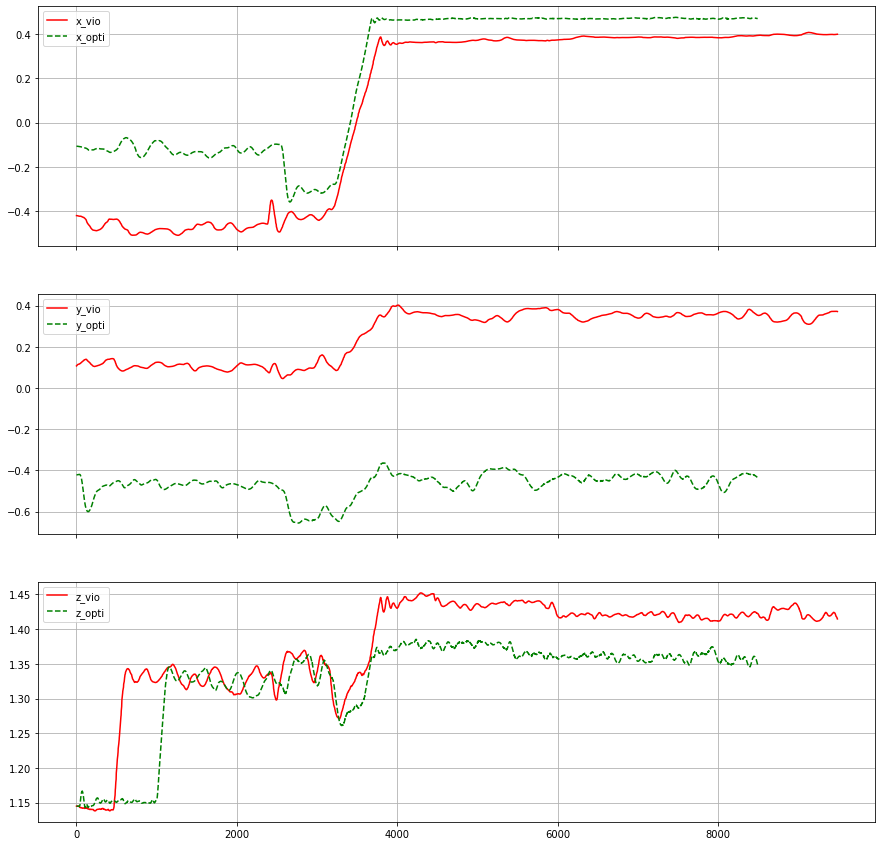

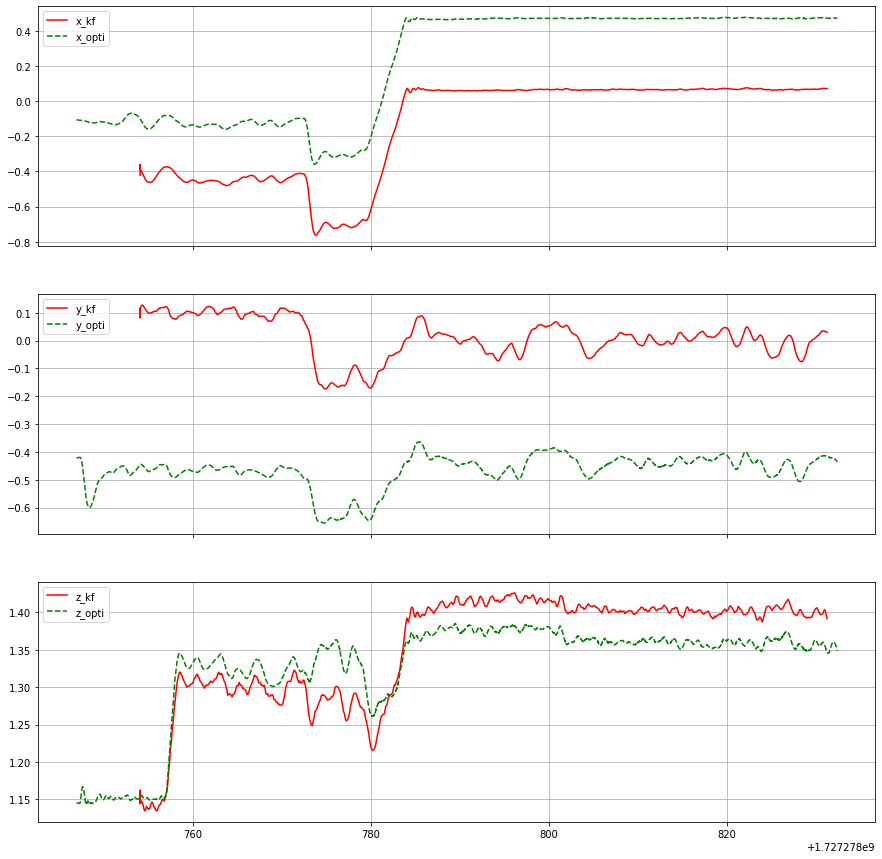

In [68]:
plot_vio_vs_opti(T_vio_w, T_uav)
plot_kf_vs_opti(df_kf['Time'], df_opt_elios['Time'], T_kf_w, T_uav)

In [70]:
Tviow = np.matmul(wTb, T_rot)
T_vio_w = [np.matmul(Tviow, Tvio_) for Tvio_ in T_vio]

Tkfw = np.matmul(wTb, T_rot)
T_kf_w = [np.matmul(Tkfw, Tkf_) for Tkf_ in T_kf]

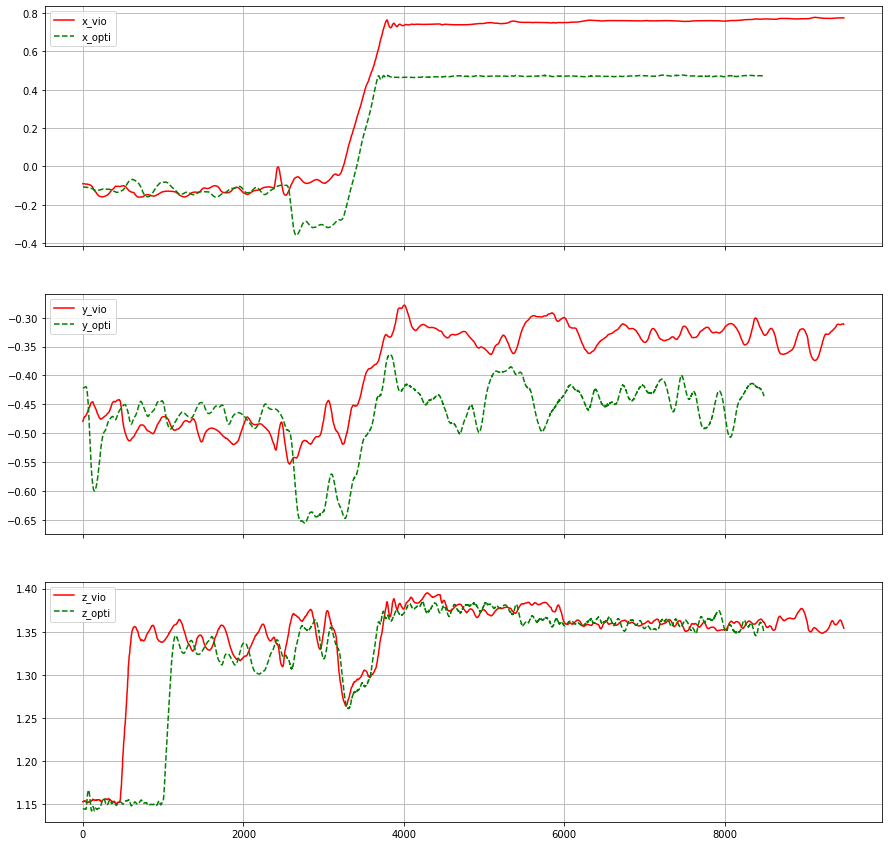

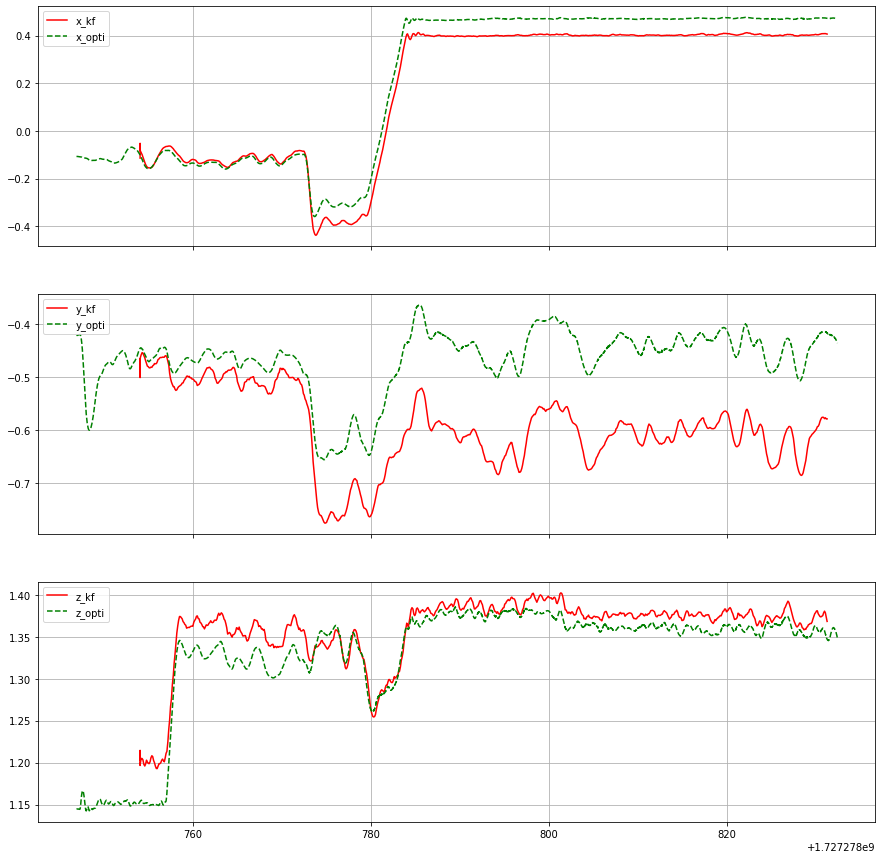

In [71]:
plot_vio_vs_opti(T_vio_w, T_uav)
# ================================================================
plot_kf_vs_opti(df_kf['Time'], df_opt_elios['Time'], T_kf_w, T_uav)

## TODO: 
- [ ] Zapisati formalizam 
- [ ] Y je zeznut 
- [ ] Uključiti i točke koje moramo pickati kao relevantne (snimiti bag s time)

In [32]:
vioTb = T_vio[0]
wTb = T_uav[0]
kfTb = T_kf[0]

In [33]:
vioTw = np.matmul(vioTb, np.linalg.inv(wTb))
kfTw = np.matmul(kfTb, np.linalg.inv(wTb))

In [34]:
print(vioTw)
wTvio = np.linalg.inv(vioTw)
wTkf = np.linalg.inv(kfTw)

[[ 0.99816557  0.05393668 -0.02750142  0.21732686]
 [-0.05151522  0.99528108  0.08222991  0.33860584]
 [ 0.03180685 -0.08066233  0.99623386 -1.15601781]
 [ 0.          0.          0.          1.        ]]


In [50]:
wTb_vio = [np.matmul(wTvio, vioTb) for vioTb in T_vio]
wTb_kf = [np.matmul(wTkf, kfTb) for kfTb in T_kf]

T = np.array([[0, 1, 0, 0],
              [-1, 0, 0, 0],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])

wTb_vio_ = [np.matmul(T, T_) for T_ in wTb_vio]
wTb_kf_ = [np.matmul(T, T_) for T_ in wTb_kf]

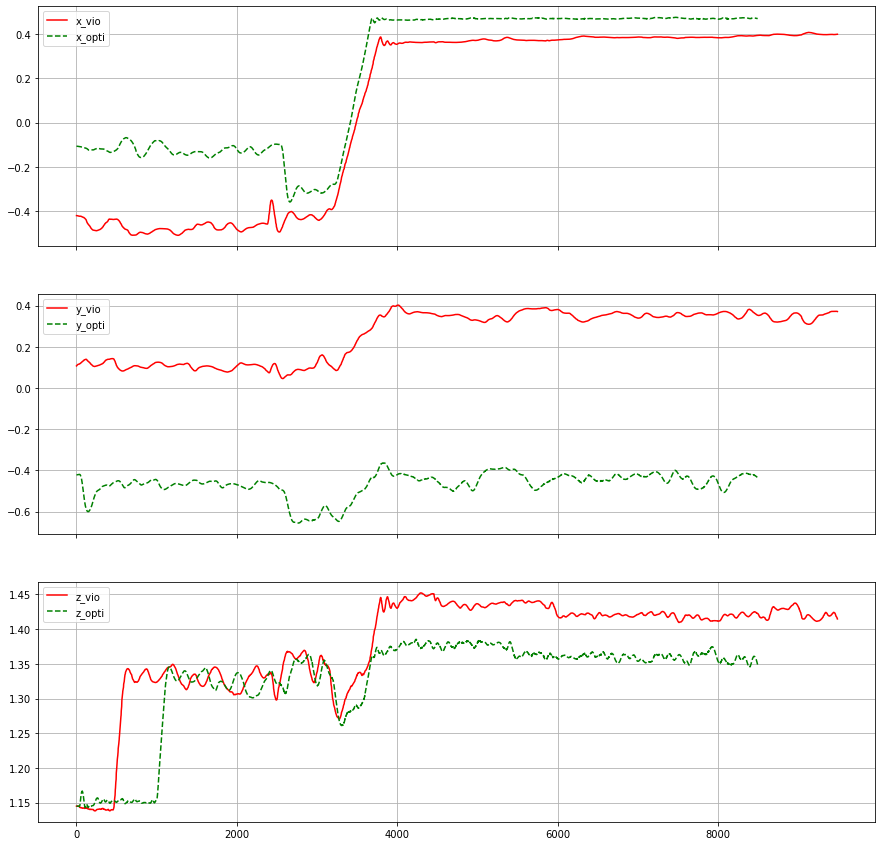

In [54]:
plot_vio_vs_opti(wTb_vio_, T_uav)

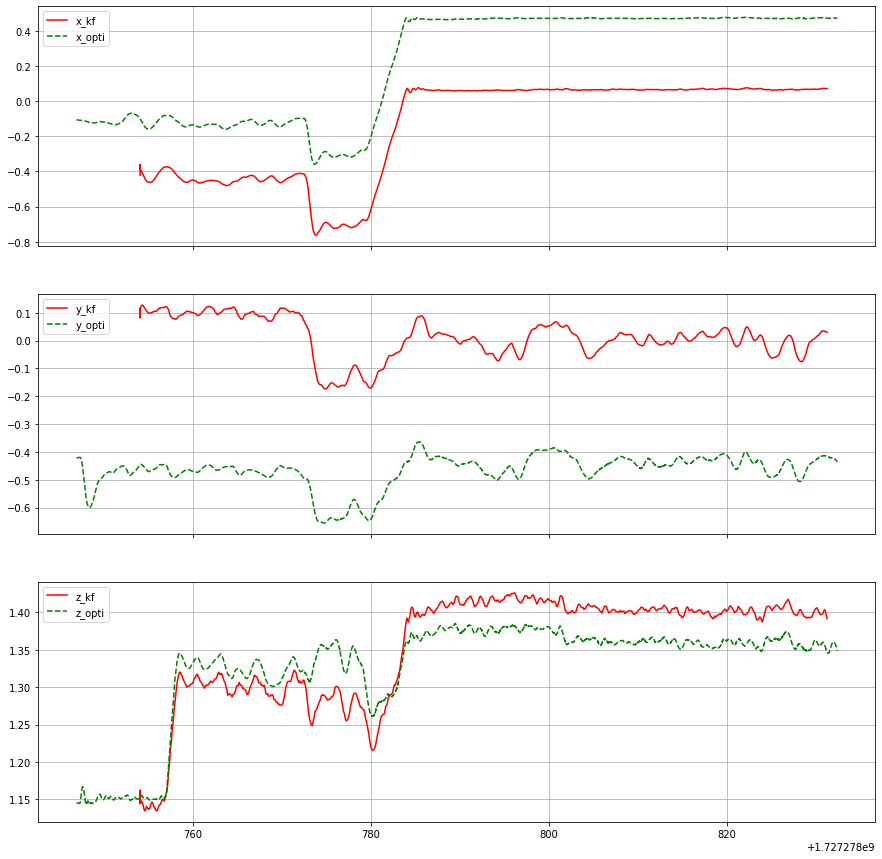

In [55]:
plot_kf_vs_opti(df_kf['Time'], df_opt_elios['Time'], wTb_kf_, T_uav)